In [1]:
import sys
import random
import numpy as np

np.random.seed(10)

sys.path.append("../")
import pandas as pd
import os


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
)
from itertools import permutations
from typing import List, Tuple

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import src.preprocessing as pp
pd.get_option("display.max_rows")

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import lightgbm as lgb
import shap
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

c:\Users\hannah.alexander\Anaconda3\envs\speed_date_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
to_drop = ["date_id_a", "date_id_b", "wave_a", "wave_b", 'Unnamed: 0', "latitude_a", "latitude_b", "longitude_a", "longitude_b", "distance", "from_a", "from_b", "zipcode_a", "zipcode_b"] #TODO clean text in from column

categorical = ["income_a", "income_b", "distance_bin", "zipcode_area_a", "zipcode_area_b"]

In [3]:
# read in data
df = pd.read_csv("../data/interim/single_row_date.csv")
df.drop(to_drop, axis = 1, inplace = True)

In [4]:
df["zipcode_area_b"] = df["zipcode_area_b"].replace("Not", "0")
df["zipcode_area_a"] = df["zipcode_area_a"].replace("Not", "0")

In [5]:
df = pd.get_dummies(df, columns = categorical)

In [6]:
# replace "Not applicable" with -1
df.columns[df.isnull().any()].tolist()
df.isnull().sum().sort_values(ascending=False).head(10)
df.dropna(inplace=True)

In [7]:
X = df[[column for column in df.columns if column!="match_a"]]
y = df["match_a"]

In [8]:
# splitting the data into testing and training sets. 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.30, stratify=y, shuffle=True
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("baseline accuracy:", (len(y_test)-sum(y_test))/len(y_test))

(2000, 336) (2000,)
(858, 336) (858,)
baseline accuracy: 0.8333333333333334


### Look at performance of a baseline model

Precision: 0.5294117647058824
Recall: 0.1888111888111888
Accuracy: 0.8368298368298368
F1 Score: 0.2783505154639175


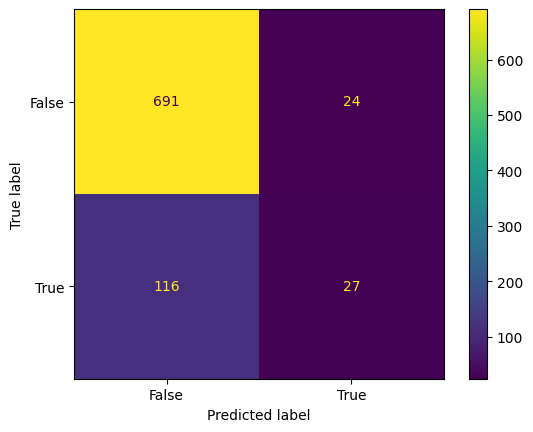

In [9]:
# default
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
pp.scoring_func(y_test, clf.predict(X_test))

### Look at upsampling for baseline model

In [10]:
# create dataframe which only contains training data to do the upsampling on
train_df = X_train.copy()
train_df["match_a"] = y_train

In [11]:
# looking for best performing upsample multiplier
# for m in [1.2, 1.5, 1.7, 2, 2.2, 2.5, 2.7, 3]:
#     print("Upsample multiplier: ", m)
#     pp.resample_data(train_df, m, X_test, y_test, lgb.LGBMClassifier())

X_train shape is:  (2499, 336) X_train shape is:  (2499,)
Precision: 0.5538461538461539
Recall: 0.2517482517482518
Accuracy: 0.8414918414918415
F1 Score: 0.34615384615384615


LGBMClassifier(random_state=42)

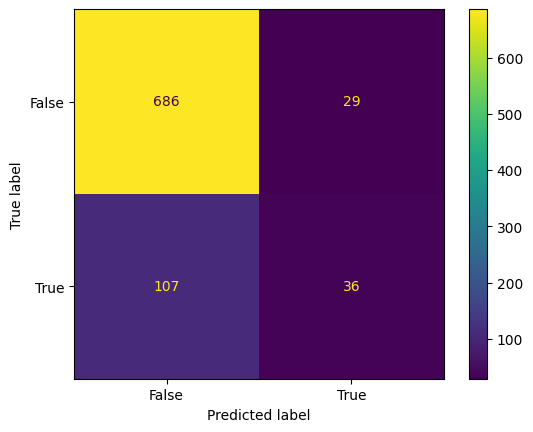

In [12]:
# the above multipliers were tried
# best performing found to be at 2.5
pp.resample_data(train_df, 2.5, X_test, y_test, lgb.LGBMClassifier(random_state=42))

### Add hyperparameter tuning to improve model
#### No Upsampling
**Optimising F1 Score**

In [13]:
# print("X_train shape is: ", X_train.shape, "X_train shape is: ", y_train.shape)

# model = lgb.LGBMClassifier()
# hyperparams = dict(application=["binary"],
#                    objective=["binary"],
#                    metric=["f1_micro", "logloss", "auc", "accuracy"],
#                    boosting_type=["gbdt", "dart", "rf"],
#                    num_leaves=[5, 7, 31],#, 1000, 4095
#                    scale_pos_weight=[1, 50, 100], #, 300, 10000
#                    min_child_weight =[0.01, 100],
#                    subsample = [0.4, 1],
#                    colsample_bytree = [0.4, 1],
#                    feature_fraction=[0.5, 0.6],
#                    bagging_fraction=[0.5, 0.7],
#                    verbose=[0],
#                    random_state=[42]
#                    )
# clf = GridSearchCV(model, hyperparams, scoring="f1_micro", verbose=0, cv=5, n_jobs=1)
# best_model = clf.fit(X_train, y_train)

In [14]:
#clf.best_estimator_.get_params()

In [15]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.4,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.01,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 7,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.4,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'application': 'binary',
 'bagging_fraction': 0.5,
 'feature_fraction': 0.5,
 'metric': 'f1_micro',
 'scale_pos_weight': 1,
 'verbose': 0}

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
Precision: 0.8
Recall: 0.13986013986013987
Accuracy: 0.8508158508158508
F1 Score: 0.2380952380952381


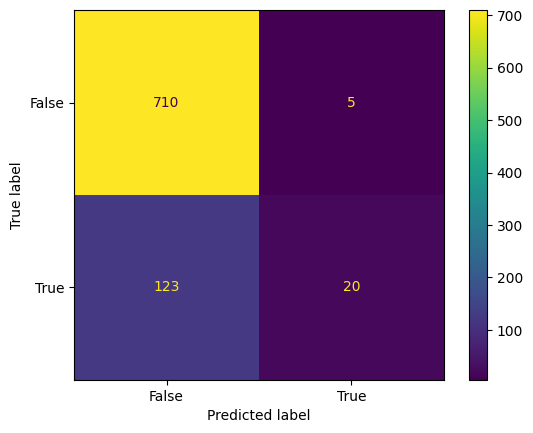

In [16]:
best_model = lgb.LGBMClassifier(**best_params) #clf.best_estimator_.get_params()
best_model.fit(X_train, y_train)
pp.scoring_func(y_test, best_model.predict(X_test)) 

Accuracy and precision are high.
Precision is defined as the ratio between all the instances that were correctly classified in the positive class against the total number of instances classified in the positive class. In other words, it's the percentage of the instances classified in the positive class that is actually right.
We can assume that people who go speed dating are open to meeting new people, but they don't want to miss getting paired with their sole mate! Therefore, we'd rather predict more dates to be matches than the other way around.

#### Use best sampling from baseline model with hyperparameters tuned

X_train shape is:  (2499, 336) X_train shape is:  (2499,)
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] baggin

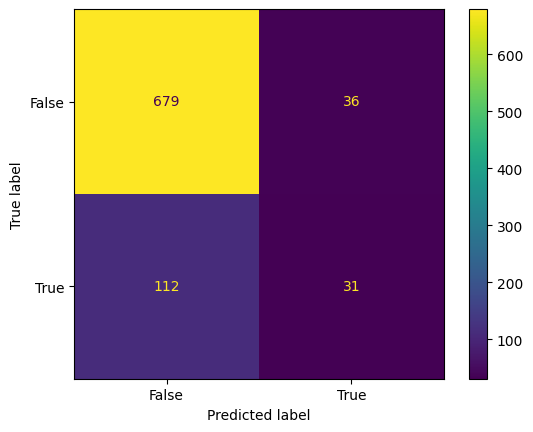

In [18]:
# create dataframe which only contains training data to do the upsampling on
train_df = X_train.copy()
train_df["match_a"] = y_train

clf_resample = pp.resample_data(train_df, 2.5, X_test, y_test, best_model)